In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import csr_matrix, save_npz
from sklearn.neighbors import NearestNeighbors
import joblib
from scipy.sparse import load_npz

In [ ]:
import pyarrow as pa
import pyarrow.parquet as pq

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
movie_dataset = pd.read_csv("/content/drive/MyDrive/4cinephile/dataset/movie.csv")
rating_dataset = pd.read_csv("/content/drive/MyDrive/4cinephile/dataset/rating.csv")

In [ ]:
movie_dataset.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
rating_dataset.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


Exploratory Data Analysis

In [ ]:
number_ratings = len(rating_dataset)
number_movies = len(movie_dataset)
number_of_unique_users = rating_dataset['userId'].nunique()
number_of_unique_movies = rating_dataset['movieId'].nunique()

print("Number of rows in movies dataset = {}".format(number_movies))
print("Number of rows in ratings dataset = {}".format(number_ratings))
print("Number of unique users in ratings dataset = {}".format(number_of_unique_users))
print("Number of unique movies in ratings dataset = {}".format(number_of_unique_movies))

Number of rows in movies dataset = 27278
Number of rows in ratings dataset = 4049357
Number of unique users in ratings dataset = 27551
Number of unique movies in ratings dataset = 19396


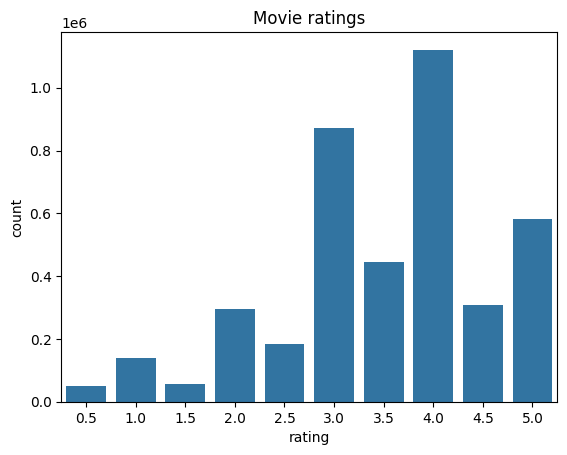

In [ ]:
sns.countplot(x='rating',data=rating_dataset)
plt.title("Movie ratings")
plt.show()

In [ ]:
mean_ratings_per_user = rating_dataset.groupby('userId')['rating'].mean()
print(mean_ratings_per_user)

total_mean_ratings = mean_ratings_per_user.mean()
print("Overall mean rating : ",total_mean_ratings)

userId
1        3.742857
2        4.000000
3        4.122995
4        3.571429
5        4.272727
           ...   
27547    3.687500
27548    4.488095
27549    3.284416
27550    3.513514
27551    2.898810
Name: rating, Length: 27551, dtype: float64
Overall mean rating :  3.6218345318971847


In [ ]:
#Find mostly frequently rated movie
movie_ratings = pd.merge(movie_dataset,rating_dataset,on='movieId')
print(movie_ratings.head())

   movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating            timestamp  
0       3     4.0  1999-12-11 13:36:47  
1       6     5.0  1997-03-13 17:50:52  
2       8     4.0  1996-06-05 13:37:51  
3      10     4.0  1999-11-25 02:44:47  
4      11     4.5  2009-01-02 01:13:41  


In [ ]:
mean_ratings = movie_ratings.groupby('movieId')[['rating']].mean()
print("The least rated movies are : ")
lowest_rated = mean_ratings['rating'].idxmin()
print(movie_ratings[movie_ratings['movieId']==lowest_rated])

print("The highly rated movies are : ")
highest_rated = mean_ratings['rating'].idxmax()
print(movie_ratings[movie_ratings['movieId']==highest_rated])



The least rated movies are : 
         movieId                              title                    genres  \
2711885     3582  Jails, Hospitals & Hip-Hop (2000)  Comedy|Documentary|Drama   

         userId  rating            timestamp  
2711885   22971     0.5  2011-02-16 00:58:17  
The highly rated movies are : 
         movieId                        title       genres  userId  rating  \
3419383     7145  Prisoner of Paradise (2002)  Documentary   18628     5.0   

                   timestamp  
3419383  2003-12-15 14:47:14  


If we observe properly then Sonic Outlaws has highest rating, but the issue is there are only 3 ratings for that movie.

Consider a case : only rated once, but it is rated 5
Other case : A movie is rated 1000 times and everytime it is rated 4.That means that it is more popular, but it is recommended as it's rating is low.
But actually, it's more viewed so we should be recommended that.

Thus, there is issue we need ratings with respect to number of ratings

To solve this issue, we use
### Bayesian Average

bayesian(ratings):
Bayesian Average = ( C * m + (ratings.mean()))/ (C + ratings.count())


In [ ]:
movie_stats = movie_ratings.groupby('movieId')['rating'].agg(['count','mean'])
print(movie_stats.head())

         count      mean
movieId                 
1         9877  3.912777
2         4471  3.201074
3         2537  3.148207
4          570  2.876316
5         2402  3.071607


In [ ]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

In [ ]:
bayesian_rating_dataset = rating_dataset.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_rating_dataset.columns = ['movieId','bayesian_avg']
movie_stats = pd.merge(movie_stats,bayesian_rating_dataset,on='movieId')
print(movie_stats.head())

   movieId  count      mean  bayesian_avg
0        1   9877  3.912777         3.898
1        2   4471  3.201074         3.200
2        3   2537  3.148207         3.150
3        4    570  2.876316         2.957
4        5   2402  3.071607         3.080


In [ ]:
movie_stats = movie_stats.merge(movie_dataset[['movieId', 'title']])
print(movie_stats.sort_values('bayesian_avg', ascending=False).head())
print("--------------------------")
print(movie_stats.sort_values('bayesian_avg', ascending=True).head())

      movieId  count      mean  bayesian_avg                             title
315       318  12702  4.451346         4.431  Shawshank Redemption, The (1994)
842       858   8269  4.352038         4.323             Godfather, The (1972)
49         50   9408  4.346354         4.321        Usual Suspects, The (1995)
523       527  10154  4.300965         4.278           Schindler's List (1993)
1193     1221   5436  4.281181         4.240    Godfather: Part II, The (1974)
--------------------------
      movieId  count      mean  bayesian_avg                           title
3488     3593    811  1.563502         1.894        Battlefield Earth (2000)
1504     1556   1088  1.880515         2.089  Speed 2: Cruise Control (1997)
1692     1760    576  1.763889         2.140              Spice World (1997)
1646     1707    518  1.774131         2.177             Home Alone 3 (1997)
542       546   1169  2.020530         2.196        Super Mario Bros. (1993)


Separate out the genres in form of list. If we observe carefully, in dataset, it is in form of | separated.

In [ ]:
movie_dataset['genres'] = movie_dataset['genres'].apply(lambda x : x.split('|'))
movie_dataset.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [ ]:
from collections import Counter

genre_frequency = Counter(g for genres in movie_dataset['genres'] for g in genres)
print(genre_frequency.most_common(5))

[('Drama', 13344), ('Comedy', 8374), ('Thriller', 4178), ('Romance', 4127), ('Action', 3520)]


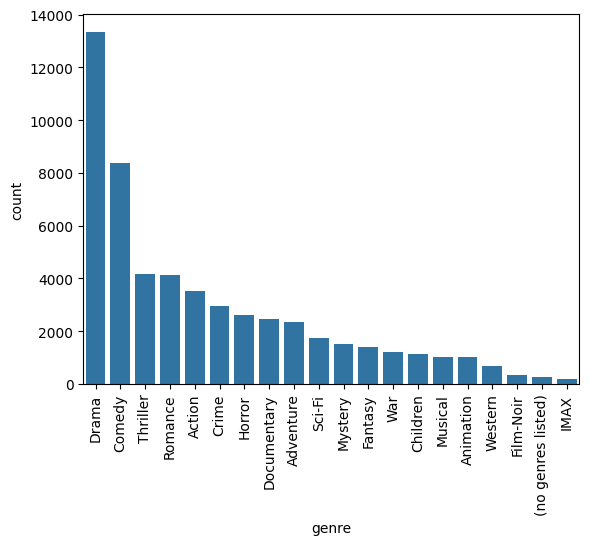

In [ ]:
df_genre = pd.DataFrame([genre_frequency]).T.reset_index()
df_genre.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=df_genre.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()

Building utility matrix

---



---

USERS - ROWS <br>
MOVIES - COLUMNS

In [ ]:
def create_utility_matrix(df):
  #Consider m x n matrix, m users and n movies
  m = df['userId'].nunique()
  n = df['movieId'].nunique()
  user_index = dict(zip(np.unique(df["userId"]), list(range(m))))
  index_user = dict(zip(list(range(m)), np.unique(df["userId"])))
  movie_index = dict(zip(np.unique(df["movieId"]), list(range(n))))
  index_movie = dict(zip(list(range(n)), np.unique(df["movieId"])))
  user_index_fromdict = [user_index[i] for i in df['userId']]
  movie_index_fromdict = [movie_index[i] for i in df['movieId']]
  mat = csr_matrix((df["rating"], (user_index_fromdict,movie_index_fromdict)), shape=(m,n))
  return mat,user_index,index_user,movie_index,index_movie

mat,user_index,index_user,movie_index,index_movie = create_utility_matrix(rating_dataset)
mat.shape

(27551, 19396)

In [ ]:
mat

<27551x19396 sparse matrix of type '<class 'numpy.float64'>'
	with 4049357 stored elements in Compressed Sparse Row format>

In [ ]:
totalCells = mat.shape[0]*mat.shape[1]
rated = mat.nnz
sparsity = rated/totalCells
#Shows stored_cells/Total_cells
print("Sparsity is : ",sparsity)

Sparsity is :  0.0075776845923470415


In [ ]:
n_ratings_per_user = mat.getnnz(axis=1)
len(n_ratings_per_user)

27551

In [ ]:
n_ratings_per_movie = mat.getnnz(axis=0)
len(n_ratings_per_movie)

19396

<ipython-input-23-65ab2f798046>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_user, shade=True)
<ipython-input-23-65ab2f798046>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_movie, shade=True)


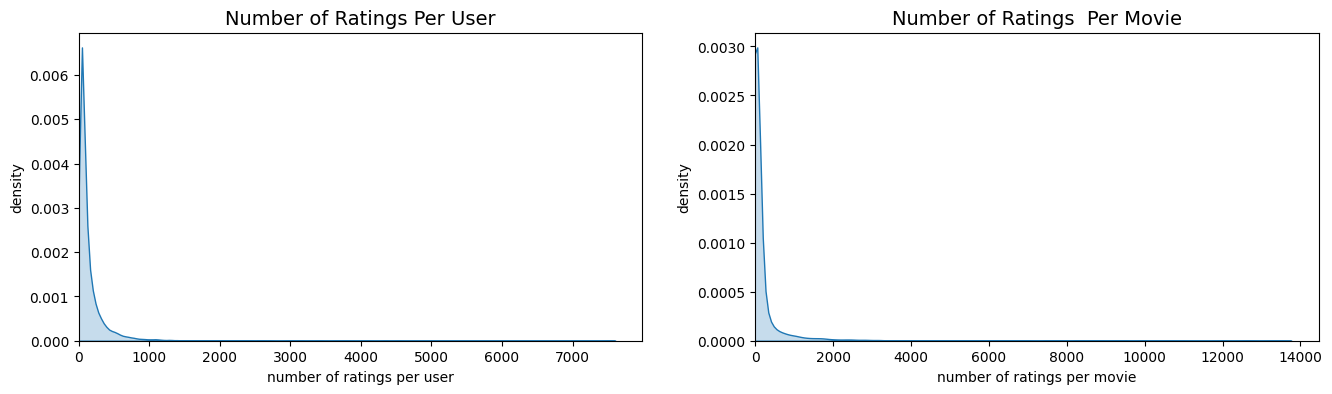

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Number of Ratings  Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

## **Model Export and Load**

In [ ]:

def find_similar_movies(movie_id, mat , movie_index, index_movie, k=10, metric='cosine'):
    mat = mat.T
    nearest_k_ids = []

    movieIdx = movie_index[movie_id]
    movie_vec = mat[movieIdx]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(mat)
    joblib.dump(kNN,'./Recommendation_System.sav')
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        nearest_k_ids.append(index_movie[n])
    nearest_k_ids.pop(0)
    return nearest_k_ids

In [ ]:
movie_dataset.to_parquet('./movie_database.parquet',engine='fastparquet',index=False)
save_npz('utility_matrix.npz', mat)
joblib.dump(user_index,'./user_index.pkl')
joblib.dump(index_user,'./index_user.pkl')
joblib.dump(movie_index,'./movie_index.pkl')
joblib.dump(index_movie,'./index_movie.pkl')

['./index_movie.pkl']

In [ ]:
movie_dataset = pd.read_parquet('./movie_database.parquet')
mat = load_npz('./utility_matrix.npz')
user_index = joblib.load('./user_index.pkl')
index_user = joblib.load('./index_user.pkl')
movie_index = joblib.load('./movie_index.pkl')
index_movie = joblib.load('./index_movie.pkl')
model = joblib.load('./Recommendation_System.sav')
movie_title = 'Toy Story (1995)'

In [ ]:
def get_recommendations(movie_title,model, mat, k=11):
    titleofmovie = dict(zip(movie_dataset['title'], movie_dataset['movieId']))
    titleofmovie_new = dict(zip(movie_dataset['movieId'], movie_dataset['title']))
    movie_id = titleofmovie[movie_title]
    mat = mat.T
    nearest_k_ids = []
    nearest_movie_name = []
    movieIdx = movie_index[movie_id]
    movie_vec = mat[movieIdx]
    neighbour = model.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        nearest_k_ids.append(index_movie[n])
        nearest_movie_name.append(titleofmovie_new[index_movie[n]])
    nearest_k_ids.pop(0)
    nearest_movie_name.pop(0)
    return nearest_movie_name

In [ ]:
get_recommendations(movie_title,model,mat)

['Star Wars: Episode IV - A New Hope (1977)',
 'Independence Day (a.k.a. ID4) (1996)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Back to the Future (1985)',
 'Forrest Gump (1994)',
 'Toy Story 2 (1999)',
 'Aladdin (1992)',
 'Mission: Impossible (1996)',
 'Jurassic Park (1993)',
 'Lion King, The (1994)']